In [1]:
import os 
import sys
import random
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import lognorm
from scipy.stats import norm 
from scipy import integrate
from scipy.stats import gmean

from scipy.stats import pearsonr

import statsmodels.api as sm 
import statsmodels.formula.api as smf

### src; https://github.com/arkottke/pyrotd
import pyrotd



/Users/laxmandahal/opt/miniconda3/lib/python3.8/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
with open('BuildingNames.txt', 'r') as f:
    BuildingList = f.read() 
BuildingList = BuildingList.split('\n')
BuildingList

['s1_48x32_high',
 's1_48x32_veryhigh',
 's1_96x48_high',
 's1_96x48_veryhigh',
 's2_48x32_high',
 's2_48x32_veryhigh',
 's2_96x48_high',
 's2_96x48_veryhigh',
 's4_96x48_high',
 's4_96x48_veryhigh']

In [3]:
baseDir = r'/Users/laxmandahal/Desktop/UCLA/Phd/Research/IM_study'

## time period of the buildings
T = np.array([0.13, 0.12, 0.22, 0.22, 0.16, 0.15, 0.26, 0.25, 0.49, 0.49])

numGM = 826
g = 980.665 ## converts GM record to cm/sec^2

def compute_RotDxx_EDP(edpX, edpZ, percentile = 50):
    angles = np.arange(0, 180, step=1)
    radians = np.radians(angles)
    coeffs = np.c_[np.cos(radians), np.sin(radians)]
    
    edp_stacked = np.vstack([edpX, edpZ])
    rotated_edp = np.dot(coeffs, edp_stacked)
    percentile_edp = np.percentile(rotated_edp, q = percentile, axis = 0, interpolation='linear')
    return percentile_edp
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

In [4]:
# heresi_GM_dir = os.path.join(baseDir, *['References', 'Heresi GMs'])
# os.chdir(heresi_GM_dir)
# heresiGM = pd.read_csv('Ground Motion Records.csv')
# RSNs = heresiGM['Record Sequence Number\n(NGA-West2)'].values
# np.savetxt('Heresi_831_RSNs.txt',[RSNs], delimiter=',', fmt='%d')

In [5]:
gminfo_h1 = pd.read_csv(r'data/Complete_GM_info_h1.csv')
gminfo_h1 = gminfo_h1.set_index('key_0')
gminfo_h1.index.names = ['GMID']

In [6]:
gminfo_h2 = pd.read_csv(r'data/Complete_GM_info_h2.csv')
gminfo_h2 = gminfo_h2.set_index('key_0')
gminfo_h2.index.names = ['GMID']

In [7]:
gminfo_rotD50 = pd.read_csv(r'data/Complete_GM_info_RotD50.csv')
gminfo_rotD50 = gminfo_rotD50.set_index('key_0')
gminfo_rotD50.index.names = ['GMID']
gminfo_rotD50.columns

Index(['PGA', 'PGV', 'DS_5to75', 'DS_5to95', 'CAV', 'T_0.01', 'T_0.02',
       'T_0.03', 'T_0.04', 'T_0.05',
       ...
       'SI', 'ASI', 'DSI', 'Sa_avg', '5-75% Duration (sec)_NGA2',
       '5-95% Duration (sec)_NGA2', 'Magnitude', 'Distance_Rjb',
       'Distance_rup', 'Vs_30'],
      dtype='object', length=156)

In [8]:
sv_rotD50 = pd.read_csv('data/Spectral_velocity_rotD50.csv', index_col='GMID')
sd_rotD50 = pd.read_csv('data/Spectral_Displacement_rotD50.csv', index_col='GMID')

In [9]:
# os.chdir(os.path.join(baseDir, *['Codes', 'data']))
# np.savetxt('Magnitude.txt', gminfo_rotD50['Magnitude'].values, fmt = '%.3f')
# np.savetxt('Distance_Rjb.txt', gminfo_rotD50['Distance_Rjb'].values, fmt = '%.3f')

## Defining Classes for efficiency and sufficiency

In [10]:
def extract_EDP_data(baseDir, buildingIndex, edp_type = 'SDR', pairingID = 1, 
                     direction = 'X', remove_collapse = False):
    
    dataDir = dataDir = os.path.join(baseDir, *['Results', 'IM_study_826GMs', BuildingList[buildingIndex]])
#     dataDir = dataDir = os.path.join(baseDir, *['Results', 'IM_study', BuildingList[buildingIndex]])
    edp = pd.read_csv(os.path.join(dataDir, '%s.csv'%edp_type), header = None)
    
    numStory = int(BuildingList[buildingIndex].split('_')[0][1])
    base_col_names = ['Hazard_Level', 'Pairing_ID', 'GM_ID']
    if edp_type == 'PFA':
        story_col_name = ['Story_%i'%x for x in range(numStory + 1)]
    else:
        story_col_name = ['Story_%i'%x for x in range(1, numStory + 1)]
    col_names = base_col_names + story_col_name
    edp = edp.rename(columns = dict(zip(edp.columns, col_names)))
    
    if pairingID == 1:
        edp = edp[edp['Pairing_ID'] == pairingID]
        start_index_multiplier = 0
        end_index_multiplier = 1
    elif pairingID == 2:
        edp = edp[edp['Pairing_ID'] == pairingID]
        start_index_multiplier = 2
        end_index_multiplier = 3
    else:
        pass
        
    
    if direction == 'X':
        edp = edp[(edp['GM_ID']> 826 * start_index_multiplier) & (edp['GM_ID']<= 826 * end_index_multiplier)]
    else:
        edp = edp[(edp['GM_ID']> 826 * end_index_multiplier) & (edp['GM_ID']<= 826 * (end_index_multiplier + 1))]
    
    if edp_type == 'SDR':
        if remove_collapse:
            edp = edp[edp['Story_1'] < 0.1]
    edp['Max_EDP'] = edp.loc[:,story_col_name].max(axis=1)
    
    return edp

In [19]:
sdr = extract_EDP_data(baseDir, 9, edp_type='SDR', pairingID=1, direction='Z', remove_collapse=False)
sdr.head()

,Hazard_Level,Pairing_ID,GM_ID,Story_1,Story_2,Story_3,Story_4,Max_EDP
826,1,1,827,0.002964,0.002030,0.001032,0.000176,0.002964
827,1,1,828,0.002864,0.001884,0.000790,0.000243,0.002864
828,1,1,829,0.004377,0.003890,0.002114,0.001051,0.004377
829,1,1,830,0.002904,0.001953,0.001726,0.001131,0.002904
830,1,1,831,0.002856,0.001947,0.000874,0.000185,0.002856


In [20]:
sdr[sdr['Hazard_Level']==1].describe()

,Hazard_Level,Pairing_ID,GM_ID,Story_1,Story_2,Story_3,Story_4,Max_EDP
count,826.0,826.0,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000
mean,1.0,1.0,1239.500000,0.003989,0.002477,0.001345,0.000428,0.003991
std,0.0,0.0,238.589955,0.006390,0.001940,0.001449,0.000467,0.006390
min,1.0,1.0,827.000000,0.000649,0.000509,0.000299,0.000010,0.000649
25%,1.0,1.0,1033.250000,0.002131,0.001531,0.000732,0.000139,0.002134
50%,1.0,1.0,1239.500000,0.002969,0.001966,0.000949,0.000265,0.002975
75%,1.0,1.0,1445.750000,0.003814,0.002538,0.001253,0.000571,0.003814
max,1.0,1.0,1652.000000,0.106067,0.014933,0.010851,0.003949,0.106067


In [21]:
np.median(sdr.Story_1)

0.002969115

In [24]:
pfa = extract_EDP_data(baseDir, 9, edp_type='PFA', pairingID=1, direction='Z', remove_collapse=True)
pfa = pfa[pfa['GM_ID'].isin(sdr['GM_ID'].values)]
pfa.head()

,Hazard_Level,Pairing_ID,GM_ID,Story_0,Story_1,Story_2,Story_3,Story_4,Max_EDP
826,1,1,827,0.045270,0.085317,0.111551,0.114419,0.128071,0.128071
827,1,1,828,0.059029,0.118398,0.180858,0.168013,0.178223,0.180858
828,1,1,829,0.368237,0.721778,0.843903,0.881731,0.986480,0.986480
829,1,1,830,0.271781,0.500525,0.580342,0.561967,0.745916,0.745916
830,1,1,831,0.057533,0.133925,0.125278,0.120166,0.131927,0.133925


In [25]:
pfa.shape

(826, 9)

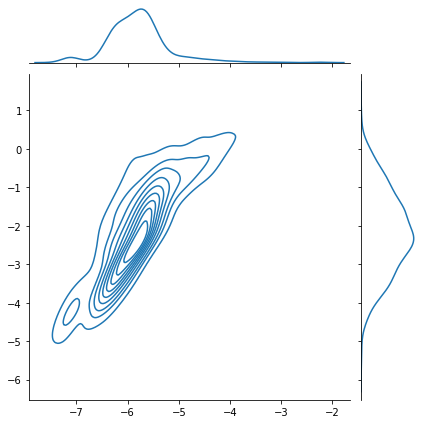

In [26]:

sns.jointplot(x = np.log(sdr['Story_1'].values), y = np.log(pfa['Story_1'].values), kind='kde')


Text(27.0, 0.5, 'Max PFA')

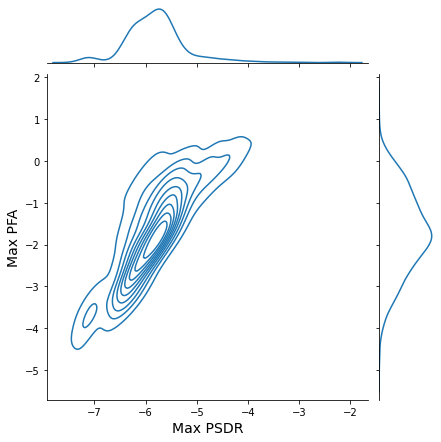

In [34]:
# fig, ax = plt.subplots(figsize=(10,10))
g = sns.jointplot(x = np.log(sdr['Max_EDP'].values), y = np.log(pfa['Max_EDP'].values), kind='kde')
g.ax_joint.set_xlabel('Max PSDR', fontsize=14)
g.ax_joint.set_ylabel('Max PFA', fontsize=14)


In [ ]:
X.shape

In [ ]:
from pingouin import multivariate_normality
X = [np.log(sdr['Story_1'].values), np.log(pfa['Story_1'].values)]
# X = np.concatenate((np.log(sdr['Story_1'].values), np.log(pfa['Story_1'].values)))
X = np.array(X).T
# multivariate_normality(X, alpha=.05)
from scipy.stats import normaltest
k2, pval = normaltest(X)


In [ ]:
pval

In [ ]:
multivariate_normality(np.log(sdr[['Story_1', 'Story_2', 'Story_3', 'Story_4']]), alpha=0.05)

In [ ]:
from scipy import stats
stats.kstest(np.log(sdr['Story_1'].values), stats.norm.cdf, alternative='two-sided')

In [ ]:
stats.anderson(np.log(sdr['Story_1'].values), dist='norm')

In [ ]:
stats.shapiro(np.log(sdr['Story_4'].values))

In [ ]:
multivariate_normality(sdr[['Story_1', 'Story_2', 'Story_3', 'Story_4']], alpha=0.05)

In [ ]:
gminfo_rotD50['T_0.13'] = np.round(gminfo_rotD50['T_0.13'] / g, 1)

In [ ]:
gminfo_rotD50['T_0.13'].value_counts()

In [15]:
covariance = np.cov(np.log(sdr['Story_1'].values), np.log(pfa['Story_1'].values), ddof=0)
covariance

array([[0.39173104, 0.50035664],
       [0.50035664, 0.97075795]])

In [ ]:
correlation_from_covariance(covariance)

In [ ]:
np.std(np.log(sdr['Story_1'].values), ddof=0)**2

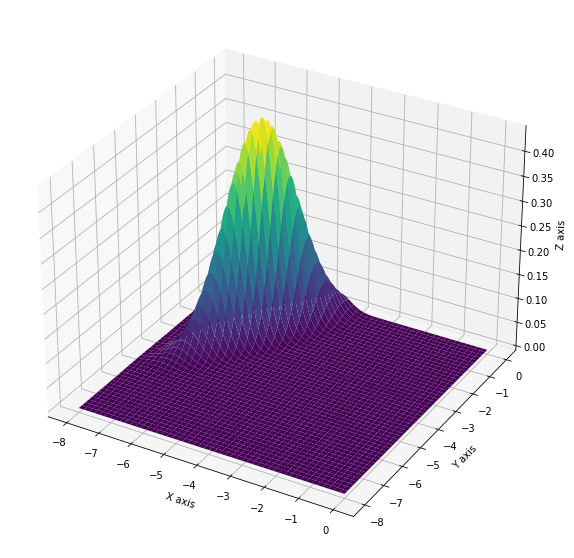

In [16]:
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

#Parameters to set
mu_x = np.mean(np.log(sdr['Story_1'].values))
variance_x = np.std(np.log(sdr['Story_1'].values))**2

mu_y = np.mean(np.log(pfa['Story_1'].values))
variance_y = np.std(np.log(pfa['Story_1'].values))**2

#Create grid and multivariate normal
x = np.linspace(-8,0,500)
y = np.linspace(-8,0,500)
X, Y = np.meshgrid(x,y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y
# pos = np.array([X.flatten(),Y.flatten()]).T
rv = multivariate_normal([mu_x, mu_y], covariance)

#Make a 3D plot
fig = plt.figure(figsize=(10,10))
# ax = fig.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, rv.pdf(pos),cmap='viridis',linewidth=0)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()

In [ ]:
class OLS:
    def __init__(self, EDP, IM):
        self.EDP = EDP
        self.IM = IM
        self.Y = np.log(EDP)
        self.X = sm.add_constant(np.log(IM))
        
        self.residual_mean = None
        self.residual_std = None
        self.xmin = None
        self.xmax = None
        
        self.fitModel()
        self.get_summary()
        
#         self.plot_residuals_hist()
#         self.plot_model_fit()
        
    def fitModel(self):
        model = sm.OLS(self.Y, self.X)
        self.result = model.fit()
        
    def get_summary(self):
        return self.result.summary()
    
    def plot_residuals_hist(self):
        fig, ax = plt.subplots()
        sns.histplot(x = self.result.resid, ax=ax, stat = 'density', linewidth = 0, kde=True)
        ax.set(title = 'Distribution of residuals', xlabel = 'residuals')
        
        self.residual_mean, self.residual_std = norm.fit(self.result.resid)
        ##plotting normal pdf
        self.xmin, self.xmax = plt.xlim() # using maxi/min values from histogram
        x = np.linspace(self.xmin, self.xmax, 200)
        pdf = norm.pdf(x, self.residual_mean, self.residual_std)
        sns.lineplot(x = x, y = pdf, color = 'red', ax = ax)
        plt.show()
    
    def get_efficiency(self):
        return np.std(self.result.resid)
            
    def qqplot(self):
        sm.qqplot(self.result.resid, line = 's')


    def fitplot(self):
        sm.graphics.plot_fit(self.result, 1, vlines = False);
        
    def plot_model_fit(self):
        Ymin = self.Y.min()
        Ymax = self.Y.max()
#         ax = sns.subplots()
        ax = sns.scatterplot(x = self.result.fittedvalues, y = self.Y)
#         ax.set_ylim(Ymin, Ymax)
#         ax.set_xlim(self.xmin, self.xmax)
        ax.set_xlabel('Predicted Values')
        ax.set_ylabel('Observed Values')
        
        X_ref = Y_ref = np.linspace(Ymin, Ymax, 200)
        plt.plot(X_ref, Y_ref, color = 'red', linewidth = 1.3)
        plt.show()
        
class Sufficiency():
    def __init__(self, ln_EDP, ln_IM, Rjb, Mag):
        self.EDP = ln_EDP
        self.IM = ln_IM
        self.X = sm.add_constant(self.IM)
        
        temp = {'I': np.ones(shape = len(Mag)),
                'lnEDP': self.EDP,
                'lnIM': self.IM,
                'lnRjb': np.log(Rjb),
                'M': Mag}
        self.dummydf = pd.DataFrame(temp, index = None)
        
        self.sufficiency_against_R()
        self.sufficiency_against_M()
        self.sufficiency_against_M_and_R()
        
    def sufficiency_against_R(self):
        self.model_IM_vs_R = smf.ols('lnEDP ~ lnIM + lnRjb', data = self.dummydf)
        model_res = self.model_IM_vs_R.fit()
        self.summary_against_R = model_res.summary()
        return model_res.pvalues['lnRjb']
        
    def sufficiency_against_M(self):
        self.model_IM_vs_M = smf.ols('lnEDP ~ lnIM + M', data = self.dummydf)
        model_res = self.model_IM_vs_M.fit()
        self.summary_against_M = model_res.summary()
        return model_res.pvalues['M']

    def sufficiency_against_M_and_R(self):
        self.model_IM_vs_R_and_M = smf.ols('lnEDP ~ lnIM + M + lnRjb', data = self.dummydf)
        model_res = self.model_IM_vs_R_and_M.fit()
        self.summary_against_M_and_R = model_res.summary()
        return model_res.pvalues
    
    def qqplot(self, model):
        sm.qqplot(model.fit(), line = 's')
      

In [ ]:
def SummaryResutls_efficiency(buildingIndex, df_IMs, IMs=['SaT1', 'PGA', 'PGV', 'Sa_avg'],
                              pairingID = 1, average_EDP = False, rotate_EDP = False):
    '''
    pairingID: if 1, GM_h1 applied in X-direction, GM_h2 applied in Y-direction
               if 2, GM_h2 applied in X-direction, GM_h1 applied in Y-direction
               
    Note:
    Care must be taken while using gminfo and pairing ID
    -------------
    df_IMs = gminfo_RotD50 can be used with pairing ID 1 OR 2 
    df_IMs = gminfo_h1 can only be used with pairing ID 1
    df_IMs = gminfo_h2 can only be used with pairing ID 2
    '''
    dataDir = os.path.join(baseDir, *['Results', 'IM_study_826GMs', BuildingList[buildingIndex]])
    os.chdir(dataDir)
    sdr = pd.read_csv('SDR.csv', header = None)
    pfa = pd.read_csv('PFA.csv', header = None)
    
    numStory = int(BuildingList[buildingIndex].split('_')[0][1])
    tempdf = []
    d = []
    keys = ['1st Story', '2nd Story', '3rd Story', '4th Story']
    temp_sdr = {}
    
    if pairingID == 1:
        start_index_multiplier = 0
        end_index_multiplier = 1
    else:
        start_index_multiplier = 2
        end_index_multiplier = 3
    
    for i in range(len(IMs)):
        if IMs[i] == 'SaT1':
            IM = df_IMs['T_%s'%T[buildingIndex]].values
            ######### result for SaT1, SvT1 and SdT1 is the same b/c they are constantly relate
#         elif IMs[i] == 'SvT1':
#             IM = sv_rotD50['T_%s'%T[buildingIndex]].values
#         elif IMs[i] == 'SdT1':
#             IM = sd_rotD50['T_%s'%T[buildingIndex]].values
        else:
            IM = df_IMs[IMs[i]]

        for j in range(numStory):
            
            sdrX = sdr[3+j].values[numGM * start_index_multiplier : numGM * end_index_multiplier]
            sdrZ = sdr[3+j].values[numGM * end_index_multiplier : numGM * (end_index_multiplier + 1)]

            pfaX = pfa[4+j].values[numGM * start_index_multiplier : numGM * end_index_multiplier]
            pfaZ = pfa[4+j].values[numGM * end_index_multiplier : numGM * (end_index_multiplier + 1)]
            
            if average_EDP:
                sdrX_avg = gmean([sdr[3+j].values[0:numGM], sdr[3+j].values[numGM*2:numGM*3]])
                pfaX_avg = gmean([pfa[4+j].values[0:numGM], pfa[4+j].values[numGM*2:numGM*3]])
                
                sdrZ_avg = gmean([sdr[3+j].values[numGM:numGM*2], sdr[3+j].values[numGM*3:numGM*4]])
                pfaZ_avg = gmean([pfa[4+j].values[numGM:numGM*2], pfa[4+j].values[numGM*3:numGM*4]])
#                 compute_RotDxx_EDP(sdrX, sdrZ, percentile=50)
#                 pfa_rotD50 = compute_RotDxx_EDP(pfaX, pfaZ, percentile=50)
                if rotate_EDP:
                    sdr_rotD50 = compute_RotDxx_EDP(sdrX_avg, sdrZ_avg, percentile=50)
                    pfa_rotD50 = compute_RotDxx_EDP(pfaX_avg, pfaZ_avg, percentile=50)
                    ols_sdrX = OLS(sdr_rotD50, IM)
                    ols_pfaZ = OLS(pfa_rotD50, IM)
                    temp_sdr[keys[j]] = {'SDR_RotD50':ols_sdrX.get_efficiency(),
                                         'PFA_RotD50': ols_pfaZ.get_efficiency()}
                else:
                    ols_sdrX = OLS(sdrX_avg, IM)
                    ols_sdrZ = OLS(sdrZ_avg, IM)
                    ols_pfaX = OLS(pfaX_avg, IM)
                    ols_pfaZ = OLS(pfaZ_avg, IM)
                    temp_sdr[keys[j]] = {'SDR_X_Avg':ols_sdrX.get_efficiency(),
                                         'SDR_Z_Avg':ols_sdrZ.get_efficiency(),
                                         'PFA_X_Avg': ols_pfaX.get_efficiency(),
                                         'PFA_Z_Avg': ols_pfaZ.get_efficiency()}
            else:
                ols_sdrX = OLS(sdrX, IM)
                ols_sdrZ = OLS(sdrZ, IM)
                ols_pfaX = OLS(pfaX, IM)
                ols_pfaZ = OLS(pfaZ, IM)
                temp_sdr[keys[j]] = {'SDR_X':ols_sdrX.get_efficiency(),
                                     'SDR_Z':ols_sdrZ.get_efficiency(),
                                     'PFA_X': ols_pfaX.get_efficiency(),
                                     'PFA_Z': ols_pfaZ.get_efficiency()}
        reform = {(outerKey, innerKey): values for outerKey, innerDict in temp_sdr.items() for innerKey, values in innerDict.items()}
        df = pd.DataFrame.from_dict(reform, orient='index').transpose()
        df.columns = pd.MultiIndex.from_tuples(df.columns)
        df['IM'] = IMs[i]
        df = df.set_index('IM')
        tempdf.append(df)

    return pd.concat(tempdf)


In [ ]:
# buildingIndex = 2
# IM_list = ['SaT1', 'PGA', 'PGV', 'Sa_avg', 'CAV', 'SI', 'ASI', 'DSI', 'SvT1', 'SdT1']
# for i in range(len(IM_list)):
#     print(IM_list[i])
#     if IM_list[i] == 'SaT1':
#         IM = gminfo_rotD50['T_%s'%T[buildingIndex]].values
#     elif IM_list[i] == 'SvT1':
        
#         IM = gminfo_rotD50['T_%s'%T[buildingIndex]].values
#         print('YES')
#     elif IM_list[i] == 'SD':
#         print('YES')
#         IM = gminfo_rotD50['T_%s'%T[buildingIndex]].values
#     else:
#         IM = gminfo_rotD50[IM_list[i]]

In [ ]:
IM_list = ['SaT1', 'PGA', 'PGV', 'Sa_avg', 'CAV', 'SI', 'ASI', 'DSI','DS_5to75', 'DS_5to95' ]
s1_48x32_high= SummaryResutls_efficiency(9, gminfo_rotD50, IM_list, pairingID = 1, average_EDP=True)
s1_48x32_high

In [ ]:
s1_48x32_high.min().min()


In [ ]:
s1_48x32_high.iloc[:, 0].values

In [ ]:
s1_48x32_high.iloc[:, 1].values[:2]

In [ ]:
fig = plt.figure(figsize=(8, 3))
ax1 = fig.add_subplot(121, projection='3d')
ax1.bar3d(x = [0.1, 0.3], y = [0.5,0.7], z = [1],
          dx = s1_48x32_high.iloc[:, 0].values[:2], dy = s1_48x32_high.iloc[:, 1].values[:2], dz = [0, 1])

In [ ]:
ax = plt.figure(figsize=(10,8)).add_subplot(projection='3d')
color_pallet = ['b', 'g', 'r', 'm', 'c', 'k', 'y', 'dodgerblue', 'lime', 'darkorange']
# Prepare arrays x, y, z
z = [1, 2]
for i in range(len(IM_list)):
    x =[s1_48x32_high.iloc[:, 0].values[i], s1_48x32_high.iloc[:, 4].values[i]]
    y = [s1_48x32_high.iloc[:, 1].values[i], s1_48x32_high.iloc[:, 5].values[i]]

    ax.plot(xs = y, ys= x, zs = z, color = color_pallet[i], label = '%s'%IM_list[i])
    ax.plot(xs = x, ys = y, zs=z, color = color_pallet[i], linestyle = '--')
# ax.legend()
# ax.view_init(elev = 30, azim= 90)
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left', ncol=1)
plt.show()

In [ ]:
ax = plt.figure(figsize=(10,8)).add_subplot(projection='3d')
color_pallet = ['b', 'g', 'r', 'm', 'c', 'k', 'y', 'dodgerblue', 'lime', 'darkorange']
# Prepare arrays x, y, z
z = [1, 2, 3, 4]
for i in range(len(IM_list)):
    x =[s1_48x32_high.iloc[:, 2].values[i], s1_48x32_high.iloc[:, 6].values[i], s1_48x32_high.iloc[:, 10].values[i], s1_48x32_high.iloc[:, 14].values[i]]
    y = [s1_48x32_high.iloc[:, 3].values[i], s1_48x32_high.iloc[:,7].values[i], s1_48x32_high.iloc[:, 11].values[i], s1_48x32_high.iloc[:, 15].values[i]]

    ax.plot(xs = y, ys= x, zs = z, color = color_pallet[i], label = '%s'%IM_list[i])
    ax.plot(xs = x, ys = y, zs=z, color = color_pallet[i], linestyle = '--')
# ax.legend()
# ax.view_init(elev = 45, azim= 120)
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left', ncol=1)
plt.show()

In [ ]:
ax = plt.figure(figsize=(10,8)).add_subplot(projection='3d')
color_pallet = ['b', 'g', 'r', 'm', 'c', 'k', 'y', 'dodgerblue', 'lime', 'darkorange']
# Prepare arrays x, y, z
z = [1, 2, 3, 4]
for i in range(len(IM_list)):
    x =[s1_48x32_high.iloc[:, 0].values[i], s1_48x32_high.iloc[:, 4].values[i], s1_48x32_high.iloc[:, 8].values[i], s1_48x32_high.iloc[:, 12].values[i]]
    y = [s1_48x32_high.iloc[:, 1].values[i], s1_48x32_high.iloc[:,5].values[i], s1_48x32_high.iloc[:, 9].values[i], s1_48x32_high.iloc[:, 13].values[i]]

    ax.plot(xs = y, ys= x, zs = z, color = color_pallet[i], label = '%s'%IM_list[i])
    ax.plot(xs = x, ys = y, zs=z, color = color_pallet[i], linestyle = '--')
# ax.legend()
ax.view_init(elev = 60, azim= 45)
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left', ncol=1)
plt.show()

In [ ]:
print(x, y)

In [ ]:
s1_48x32_high= SummaryResutls_efficiency(2, gminfo_rotD50, IM_list, pairingID = 1, average_EDP=True, rotate_EDP=True)
s1_48x32_high

In [ ]:
s1_48x32_high= SummaryResutls_efficiency(9, gminfo_rotD50, IM_list, pairingID = 1, average_EDP=True, rotate_EDP=True)
s1_48x32_high

In [ ]:
s1_48x32_high.columns

In [ ]:
s1_48x32_high.groupby([('1st Story', 'SDR_RotD50')]).mean(axis=1)

In [ ]:
s1_48x32_high= SummaryResutls_efficiency(9, gminfo_rotD50, IM_list, pairingID = 1, average_EDP=True)
s1_48x32_high

In [ ]:
s1_48x32_high= SummaryResutls_efficiency(9, gminfo_rotD50, IM_list, pairingID = 1, average_EDP=True, rotate_EDP=True)
s1_48x32_high

In [ ]:
s1_48x32_high.loc['SaT1'][1::2].values

In [ ]:
def SummaryResutls_sufficiency(buildingIndex, df_IMs, IMs=['SaT1', 'PGA', 'PGV', 'Sa_avg'],
                               pairingID = 1, fit_residual = True, average_EDP = False):
    dataDir = os.path.join(baseDir, *['Results', 'IM_study_826GMs', BuildingList[buildingIndex]])
    os.chdir(dataDir)
    sdr = pd.read_csv('SDR.csv', header = None)
    pfa = pd.read_csv('PFA.csv', header = None)
    
    numStory = int(BuildingList[buildingIndex].split('_')[0][1])
    tempdf = []
    d = []
    keys = ['1st Story', '2nd Story', '3rd Story', '4th Story']
    temp_sdr = {}
    
    if pairingID == 1:
        start_index_multiplier = 0
        end_index_multiplier = 1
    else:
        start_index_multiplier = 2
        end_index_multiplier = 3
    
    for i in range(len(IMs)):
        if IMs[i] == 'SaT1':
            IM = df_IMs['T_%s'%T[buildingIndex]].values
        else:
            IM = df_IMs[IMs[i]]

        for j in range(numStory):
                ## geometric average of EDP (in X and Z direction) between pairing ID 1 and 2
            if average_EDP: 
                sdrX = gmean([sdr[3+j].values[0:numGM], sdr[3+j].values[numGM*2:numGM*3]])
                pfaX = gmean([pfa[4+j].values[0:numGM], pfa[4+j].values[numGM*2:numGM*3]])
                
                sdrZ = gmean([sdr[3+j].values[numGM:numGM*2], sdr[3+j].values[numGM*3:numGM*4]])
                pfaZ = gmean([pfa[4+j].values[numGM:numGM*2], pfa[4+j].values[numGM*3:numGM*4]])
            else:
                sdrX = sdr[3+j].values[numGM * start_index_multiplier : numGM * end_index_multiplier]
                sdrZ = sdr[3+j].values[numGM * end_index_multiplier : numGM * (end_index_multiplier + 1)]

                pfaX = pfa[4+j].values[numGM * start_index_multiplier : numGM * end_index_multiplier]
                pfaZ = pfa[4+j].values[numGM * end_index_multiplier : numGM * (end_index_multiplier + 1)]
            
            residuals_sdrX = OLS(sdrX, IM).result.resid
            residuals_sdrZ = OLS(sdrZ, IM).result.resid
            residuals_pfaX = OLS(pfaX, IM).result.resid
            residuals_pfaZ = OLS(pfaZ, IM).result.resid
            
            if fit_residual:
                suff_sdrX = Sufficiency(residuals_sdrX, np.log(IM),
                                    df_IMs['Distance_Rjb'].values, df_IMs['Magnitude'].values)
                suff_sdrZ = Sufficiency(residuals_sdrZ, np.log(IM),
                                        df_IMs['Distance_Rjb'].values, df_IMs['Magnitude'].values)
                suff_pfaX = Sufficiency(residuals_pfaX, np.log(IM),
                                        df_IMs['Distance_Rjb'].values, df_IMs['Magnitude'].values)
                suff_pfaZ = Sufficiency(residuals_pfaZ, np.log(IM),
                                        df_IMs['Distance_Rjb'].values, df_IMs['Magnitude'].values)
            else:
                suff_sdrX = Sufficiency(np.log(sdrX), np.log(IM),
                                        df_IMs['Distance_Rjb'].values, df_IMs['Magnitude'].values)
                suff_sdrZ = Sufficiency(np.log(sdrZ), np.log(IM),
                                        df_IMs['Distance_Rjb'].values, df_IMs['Magnitude'].values)
                suff_pfaX = Sufficiency(np.log(pfaX), np.log(IM),
                                        df_IMs['Distance_Rjb'].values, df_IMs['Magnitude'].values)
                suff_pfaZ = Sufficiency(np.log(pfaZ), np.log(IM),
                                        df_IMs['Distance_Rjb'].values, df_IMs['Magnitude'].values)
            #### sufficiency against R
            p_sdrX_R = np.round(suff_sdrX.sufficiency_against_R(), 4)
            p_sdrZ_R = np.round(suff_sdrZ.sufficiency_against_R(), 4)
            p_pfaX_R = np.round(suff_pfaX.sufficiency_against_R(), 4)
            p_pfaZ_R = np.round(suff_pfaZ.sufficiency_against_R(), 4)
            #### sufficiency against M 
            p_sdrX_M = np.round(suff_sdrX.sufficiency_against_M(), 4)
            p_sdrZ_M = np.round(suff_sdrZ.sufficiency_against_M(), 4)
            p_pfaX_M = np.round(suff_pfaX.sufficiency_against_M(), 4)
            p_pfaZ_M = np.round(suff_pfaZ.sufficiency_against_M(), 4)
            temp_sdr[keys[j]] = {'SDR_X vs M':'YES(%s)'%p_sdrX_M if p_sdrX_M >= 0.05 else 'NO(%s)'%p_sdrX_M,
                                 'SDR_Z vs M':'YES(%s)'%p_sdrZ_M if p_sdrZ_M >= 0.05 else 'NO(%s)'%p_sdrZ_M,
                                 'PFA_X vs M':'YES(%s)'%p_pfaX_M if p_pfaX_M >= 0.05 else 'NO(%s)'%p_pfaX_M,
                                 'PFA_Z vs M':'YES(%s)'%p_pfaZ_M if p_pfaZ_M >= 0.05 else 'NO(%s)'%p_pfaZ_M,
                                 'SDR_X vs R':'YES(%s)'%p_sdrX_R if p_sdrX_R >= 0.05 else 'NO(%s)'%p_sdrX_R,
                                 'SDR_Z vs R':'YES(%s)'%p_sdrZ_R if p_sdrZ_R >= 0.05 else 'NO(%s)'%p_sdrZ_R,
                                 'PFA_X vs R':'YES(%s)'%p_pfaX_R if p_pfaX_R >= 0.05 else 'NO(%s)'%p_pfaX_R,
                                 'PFA_Z vs R':'YES(%s)'%p_pfaZ_R if p_pfaZ_R >= 0.05 else 'NO(%s)'%p_pfaZ_R
                                 
                                }
        reform = {(outerKey, innerKey): values for outerKey, innerDict in temp_sdr.items() for innerKey, values in innerDict.items()}
        df = pd.DataFrame.from_dict(reform, orient='index').transpose()
        df.columns = pd.MultiIndex.from_tuples(df.columns)
        df['IM'] = IMs[i]
        df = df.set_index('IM')
        tempdf.append(df)

    return pd.concat(tempdf)
IM_list = ['SaT1', 'PGA', 'PGV', 'Sa_avg', 'CAV', 'SI', 'ASI', 'DSI','DS_5to75', 'DS_5to95' ]
s1_48x32_high= SummaryResutls_sufficiency(2, gminfo_rotD50, IM_list, pairingID = 1, fit_residual=False)
s1_48x32_high

In [ ]:
s2_48x32_high= SummaryResutls_sufficiency(4, gminfo_rotD50, IM_list, fit_residual=True, average_EDP=True)
s2_48x32_high.T

In [ ]:
s4_96x48_veryhigh= SummaryResutls_sufficiency(9, gminfo_rotD50, IM_list, fit_residual=True, average_EDP=True)
s4_96x48_veryhigh.T

In [ ]:
s1_48x32_high= SummaryResutls_sufficiency(2, gminfo_rotD50, IM_list, pairingID = 1, fit_residual=False, average_EDP=True)
s1_48x32_high

In [ ]:
def plot_efficiency(buildingIndex, df_IMs, IM=['SaT1', 'PGA', 'PGV', 'Sa_avg', 'CAV'], savefig = False,
                   pairingID = 1, average_EDP = False, Uni_Direction = False):
    numStory = int(BuildingList[buildingIndex].split('_')[0][1])
    floor = np.arange(1, numStory + 1)
    
    summaryResult = SummaryResutls_efficiency(buildingIndex, df_IMs, IM, pairingID = pairingID,
                                              average_EDP=average_EDP, rotate_EDP=Uni_Direction)
    minEDP = summaryResult.min().min()
    maxEDP = summaryResult.max().max()
    xtick_value = np.arange(np.round(minEDP, 1), 1, 0.1)
    markerList = ['.', '*', '+', 'o', 's', 'p', 'd', 'X', 'v', 'D', 'P']
    colorList = ['b', 'g', 'darkorange', 'k', 'dodgerblue', 'lime', 'r', 'c', 'm', 'y']
    labelList = [r'Sa$_{T1}$', 'PGA', 'PGV', r'$Sa_{avg}$', 'CAV', 'SI', 'ASI', 'DSI', r'$DS_{5-75}$',  r'$DS_{5-95}$' ]
    
    if Uni_Direction:
        fileName = 'RotEDP_RotD50'
        fig, axs = plt.subplots(1, 2, figsize=(10,6), sharey = True)
        plt.rcParams["font.family"] = "Times New Roman"
        plt.rcParams['xtick.labelsize'] = 13
        plt.rcParams['ytick.labelsize'] = 13
#         fig.suptitle('%s Avg Rot (X+Z) EDP (pID 1&2) and GM RotD50'%BuildingList[buildingIndex], fontsize = 16)
        for i in range(len(IM)):
            axs[0].plot(summaryResult.loc['%s'%IM[i]][::2].values, floor, label = labelList[i], marker = markerList[i],
                       linewidth =1.55, markersize=5, color = colorList[i])
            axs[0].set_yticks(floor)
            axs[0].set_xticks(xtick_value)
            axs[0].set_xlabel(r'Dispersion ($\sigma_{SDR_{RotD50}|IM}$)', fontsize = 16)
            axs[0].set_ylabel('Floor Level', fontsize = 16)
#             axs[0].legend()
#             axs[1, 0].plot(summaryResult.loc['%s'%IM[i]][1::2], floor, label = IM[i], marker = markerList[i])
#             axs[1, 0].set_yticks(floor)
#             axs[1, 0].set_title('Dispersion SDR Z')
            axs[1].plot(summaryResult.loc['%s'%IM[i]][1::2], floor, label = labelList[i], marker = markerList[i],
                       linewidth =1.55, markersize=5, color = colorList[i])
            axs[1].set_yticks(floor)
            axs[1].set_xticks(xtick_value)
            axs[1].set_xlabel(r'Dispersion ($\sigma_{PFA_{RotD50}|IM}$)', fontsize = 16)
#             axs[1].set_ylabel('Floor Level', fontsize = 16)
        plt.legend(bbox_to_anchor=(1.22, 0.5), loc='center', ncol=1, fontsize = 13)

    else:
        fileName = 'AvgEDP_RotD50'
        fig, axs = plt.subplots(2, 2, figsize=(10,12), sharey = True)
        plt.rcParams["font.family"] = "Times New Roman"
        plt.rcParams['xtick.labelsize'] = 13
        plt.rcParams['ytick.labelsize'] = 13
        
#         fig.suptitle('%s EDP Pairing ID 1 and GM H1'%BuildingList[buildingIndex], fontsize = 16)
        for i in range(len(IM)):
            axs[0, 0].plot(summaryResult.loc['%s'%IM[i]][::4], floor, label = labelList[i], marker = markerList[i],
                           linewidth =1.55, markersize=5, color = colorList[i])
            axs[0, 0].set_yticks(floor)
            axs[0, 0].set_xticks(xtick_value)
            axs[0, 0].set_xlabel(r'Dispersion ($\sigma_{SDR_X|IM}$)', fontsize = 16)
            axs[0, 0].set_ylabel('Floor Level', fontsize = 16)
#             axs[0, 0].legend()
            axs[1, 0].plot(summaryResult.loc['%s'%IM[i]][1::4], floor, label = labelList[i], marker = markerList[i],
                           linewidth =1.55, markersize=5, color = colorList[i])
            axs[1, 0].set_yticks(floor)
            axs[1, 0].set_xticks(xtick_value)
            axs[1, 0].set_xlabel(r'Dispersion ($\sigma_{SDR_Z|IM}$)', fontsize = 16)
            axs[1, 0].set_ylabel('Floor Level', fontsize = 16)
            axs[0, 1].plot(summaryResult.loc['%s'%IM[i]][2::4], floor, label = labelList[i], marker = markerList[i],
                           linewidth =1.55, markersize=5, color = colorList[i])
            axs[0, 1].set_yticks(floor)
            axs[0, 1].set_xticks(xtick_value)
            axs[0, 1].set_xlabel(r'Dispersion ($\sigma_{PFA_X|IM}$)', fontsize = 16)
            axs[1, 1].plot(summaryResult.loc['%s'%IM[i]][3::4], floor, label = labelList[i], marker = markerList[i],
                           linewidth =1.55, markersize=5, color = colorList[i])
            axs[1, 1].set_yticks(floor)
            axs[1, 1].set_xticks(xtick_value)
            axs[1, 1].set_xlabel(r'Dispersion ($\sigma_{PFA_X|IM}$)', fontsize = 16)
        plt.legend(bbox_to_anchor=(1.23, 1.1), loc='center', ncol=1, fontsize = 13)
    dataDir = os.path.join(baseDir, *['Results', 'IM_study_826GMs', BuildingList[buildingIndex]])
    os.chdir(dataDir)
    
    if savefig:
        plt.savefig('%s_%s.png'%(BuildingList[buildingIndex], fileName), bbox_inches="tight")
    else:
        plt.show()



In [ ]:
for i in range(len(BuildingList)):
    plot_efficiency(i, gminfo_rotD50, IM_list, pairingID = 1, savefig=False, average_EDP=True, Uni_Direction=False)


In [ ]:
for i in range(len(BuildingList)):
    plot_efficiency(i, gminfo_rotD50, IM_list, pairingID = 1, savefig=False, average_EDP=True, Uni_Direction=True)


In [ ]:
plot_efficiency(4, gminfo_rotD50, IM_list, pairingID = 1, savefig=True, average_EDP=True, Uni_Direction=False)

In [ ]:
plot_efficiency(4, gminfo_rotD50, IM_list, pairingID = 1, savefig=True, average_EDP=True, Uni_Direction=True)

In [ ]:
def portfolio_mean_efficiency(buildingList, df_IMs, IM,
                   pairingID = 1, average_EDP = True, Uni_Direction = False):
    
    buildingName = ['IM', 'SFD1B', 'SFD3B', 'SFD2B', 'SFD4B', 'MFD1B', 'MFD4B', 'MFD2B', 'MFD5B', 'MFD3B', 'MFD6B']
    avg_sdr_eff = pd.DataFrame(data = [], columns=buildingName)
    avg_sdr_eff = avg_sdr_eff.set_index('IM')
    
    avg_pfa_eff = pd.DataFrame(data = [], columns=buildingName)
    avg_pfa_eff = avg_pfa_eff.set_index('IM')
    
    for buildingIndex in range(len(buildingList)):
        numStory = int(BuildingList[buildingIndex].split('_')[0][1])
        floor = np.arange(1, numStory + 1)
        summaryResult = SummaryResutls_efficiency(buildingIndex, df_IMs, IM, pairingID = pairingID,
                                              average_EDP=average_EDP, rotate_EDP=Uni_Direction)
        for i in range(len(IM)):
            if Uni_Direction:
                avg_sdr_eff.loc['%s'%IM[i], buildingName[buildingIndex + 1]] = np.mean(summaryResult.loc['%s'%IM[i]][::2].values)
                avg_pfa_eff.loc['%s'%IM[i], buildingName[buildingIndex + 1]] = np.mean(summaryResult.loc['%s'%IM[i]][1::2].values)
            else:
                avg_sdr_eff.loc['%s'%IM[i], buildingName[buildingIndex + 1]] = np.mean(summaryResult.loc['%s'%IM[i]][::4].values)
                avg_pfa_eff.loc['%s'%IM[i], buildingName[buildingIndex + 1]] = np.mean(summaryResult.loc['%s'%IM[i]][1::4].values)
    return avg_sdr_eff, avg_pfa_eff
        
IM_list = ['SaT1', 'PGA', 'PGV', 'Sa_avg', 'CAV', 'SI', 'ASI', 'DSI','DS_5to75', 'DS_5to95']      
SDR_mean, PFA_mean= portfolio_mean_efficiency(BuildingList, gminfo_rotD50, IM_list, average_EDP=True, Uni_Direction=True)      

In [ ]:
SDR_mean['mean'] = SDR_mean.mean(axis=1)
SDR_mean['meanSFD'] = SDR_mean.loc[:,'SFD1B':'SFD4B'].mean(axis=1)
SDR_mean['meanMFD'] = SDR_mean.loc[:,'MFD1B':'MFD6B'].mean(axis=1)


PFA_mean['mean'] = PFA_mean.mean(axis=1)
PFA_mean['meanSFD'] = PFA_mean.loc[:,'SFD1B':'SFD4B'].mean(axis=1)
PFA_mean['meanMFD'] = PFA_mean.loc[:,'MFD1B':'MFD6B'].mean(axis=1)
SDR_mean.head(n=10)

In [ ]:
PFA_mean.head(n=10)

In [ ]:
np.mean([0.13,0.13,0.22,0.22])

In [ ]:
np.mean([0.16, 0.16, 0.26, 0.26, 0.49, 0.49])

In [ ]:
PFA_mean['mean'] == PFA_mean['meanSFD']

In [ ]:
labels = [r'Sa$_{T1}$', 'PGA', 'PGV', r'$Sa_{avg}$', 'CAV', 'SI', 'ASI', 'DSI', r'$DS_{5-75}$',  r'$DS_{5-95}$' ]

meanSFD = SDR_mean['meanSFD'].values
meanMFD = SDR_mean['meanMFD'].values

x = np.arange(len(labels))  # the label locations
width = 0.30  # the width of the bars

set
rects1 = ax.bar(x - width/2, meanSFD, width, label='SFD', color = 'orangered')
rects2 = ax.bar(x + width/2, meanMFD, width, label='MFD', color = 'royalblue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(r'Dispersion ($\sigma_{SDR|IM}$)', fontsize = 20)
ax.set_xlabel('Intensity Measures', fontsize = 20)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90, ha = 'right')
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.legend(fontsize = 15)
os.chdir(r'/Users/laxmandahal/Desktop/UCLA/Phd/Research/IM_study/Paper/images')
plt.savefig('eff_regional_SDR.png', bbox_inches="tight")

In [ ]:
labels = IM_list

meanSFD = PFA_mean['meanSFD'].values
meanMFD = PFA_mean['meanMFD'].values

x = np.arange(len(labels))  # the label locations
width = 0.30  # the width of the bars

fig, ax = plt.subplots(figsize = (10,6.5))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
rects1 = ax.bar(x - width/2, meanSFD, width, label='SFD', color = 'orangered')
rects2 = ax.bar(x + width/2, meanMFD, width, label='MFD', color = 'royalblue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(r'Dispersion ($\sigma_{PFA|IM}$)', fontsize = 20)
ax.set_xlabel('Intensity Measures', fontsize = 20)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90, ha = 'right')
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.legend(fontsize = 15)
os.chdir(r'/Users/laxmandahal/Desktop/UCLA/Phd/Research/IM_study/Paper/images')
plt.savefig('eff_regional_PFA.png', bbox_inches="tight")

In [ ]:
print(gminfo_rotD50.columns.tolist())

In [ ]:
sa_list = ['T_0.01', 'T_0.05', 'T_0.10', 'T_0.11', 'T_0.12', 'T_0.13', 'T_0.14', 'T_0.15', 'T_0.16', 'T_0.17',
           'T_0.18', 'T_0.19', 'T_0.20', 'T_0.21', 'T_0.22', 'T_0.23', 'T_0.24', 'T_0.25', 'T_0.26', 'T_0.27',
           'T_0.28', 'T_0.29', 'T_0.30', 'T_0.31', 'T_0.32', 'T_0.33', 'T_0.34', 'T_0.35', 'T_0.36', 'T_0.37',
           'T_0.38', 'T_0.39', 'T_0.40', 'T_0.41', 'T_0.42', 'T_0.43', 'T_0.44', 'T_0.45', 'T_0.46', 'T_0.47',
           'T_0.48', 'T_0.49', 'T_0.50']

SDR_mean, PFA_mean= portfolio_mean_efficiency(BuildingList, gminfo_rotD50, sa_list, average_EDP=True, Uni_Direction=True)      

In [ ]:
# sa_list[0].split('_')[]
period_list = []
for ii in range(len(sa_list)):
    period_list.append(float(sa_list[ii].split('_')[1]))


In [ ]:
SDR_mean['mean'] = SDR_mean.mean(axis=1)
SDR_mean['meanSFD'] = SDR_mean.loc[:,'SFD1B':'SFD4B'].mean(axis=1)
SDR_mean['meanMFD'] = SDR_mean.loc[:,'MFD1B':'MFD6B'].mean(axis=1)
SDR_mean['weighted_mean'] = SDR_mean[['meanSFD','meanMFD']].mean(axis=1)

PFA_mean['mean'] = PFA_mean.mean(axis=1)
PFA_mean['meanSFD'] = PFA_mean.loc[:,'SFD1B':'SFD4B'].mean(axis=1)
PFA_mean['meanMFD'] = PFA_mean.loc[:,'MFD1B':'MFD6B'].mean(axis=1)
PFA_mean['weighted_mean'] = PFA_mean[['meanSFD','meanMFD']].mean(axis=1)
PFA_mean.head(200)

In [ ]:
plt.plot(period_list, SDR_mean['mean'].values)
plt.plot(period_list, SDR_mean['meanSFD'].values)
plt.plot(period_list, SDR_mean['meanMFD'].values)
plt.plot(period_list, SDR_mean[['meanSFD','meanMFD']].mean(axis=1))

In [ ]:
ytickList = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]
fig, axs = plt.subplots(1, 2, figsize=(13,7))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
markerList = ['.', '*', '+', 'o', 's', 'p', 'd', 'X', 'v', 'D', 'P']


axs[0].plot(period_list, SDR_mean['meanSFD'].values, label = 'SFD', linewidth =2, color = 'r')
axs[0].plot(period_list, SDR_mean['meanMFD'].values, label = 'MFD', linewidth =2, color = 'g')
# axs[0].plot(period_list, SDR_mean['mean'].values, label = 'All Buildings', linewidth =2, color = 'b')
axs[0].plot(period_list, SDR_mean['weighted_mean'].values, label = 'All Buildings', linewidth =2, color = 'k')
axs[0].set_ylabel(r'Dispersion ($\sigma_{SDR_{RotD50}|IM}$)', fontsize = 16)
axs[0].set_xlabel('Period (sec)', fontsize = 16)
axs[0].set_yticks(ytickList)
# axs[1].plot(period_list, PFA_mean['mean'].values, linewidth =2, color = 'b')
axs[1].plot(period_list, PFA_mean['weighted_mean'].values, linewidth =2, color = 'k')
axs[1].plot(period_list, PFA_mean['meanSFD'].values, linewidth =2, color = 'r')
axs[1].plot(period_list, PFA_mean['meanMFD'].values,linewidth =2, color = 'g')

axs[1].set_ylabel(r'Dispersion ($\sigma_{PFA_{RotD50}|IM}$)', fontsize = 16)
axs[1].set_xlabel('Period (sec)', fontsize = 16)
axs[1].set_yticks(ytickList)
axs[0].legend(loc= 'best', fontsize = 14)
os.chdir(r'/Users/laxmandahal/Desktop/UCLA/Phd/Research/IM_study/Paper/images')
plt.savefig('period_benchmark.png', bbox_inches="tight")

In [ ]:
SDR_mean[np.round(SDR_mean['weighted_mean'].values, 2) == np.round(SDR_mean['meanSFD'].values, 2)]

In [ ]:
PFA_mean[np.round(PFA_mean['weighted_mean'].values, 2) == np.round(PFA_mean['meanSFD'].values, 2)]

In [ ]:
SDR_mean['meanSFD'].idxmin()

In [ ]:
SDR_mean['weighted_mean'].idxmin()

In [ ]:
(SDR_mean.loc['T_0.24','weighted_mean'] - SDR_mean['weighted_mean'].min())*100/SDR_mean['weighted_mean'].min()

In [ ]:
(PFA_mean.loc['T_0.19','weighted_mean'] - PFA_mean['weighted_mean'].min())*100/PFA_mean['weighted_mean'].min()

In [ ]:
PFA_mean['meanSFD'].idxmin()

In [ ]:
SDR_mean['meanMFD'].idxmin()

In [ ]:
PFA_mean['weighted_mean'].idxmin()

In [ ]:
plt.plot(period_list, SDR_mean['meanSFD'].values)

In [ ]:
plt.plot(period_list, SDR_mean['meanMFD'].values)

In [ ]:
SDR_mean['mean'].plot(kind = 'bar')

In [ ]:
SDR_mean['mean'].plot(kind = 'bar')

In [ ]:
PFA_mean['mean'].plot(kind = 'bar')

In [ ]:
buildingName = ['IM', 'SFD1B', 'SFD3B', 'SFD2B', 'SFD4B', 'MFD1B', 'MFD4B', 'MFD2B', 'MFD5B', 'MFD3B', 'MFD6B']
df = pd.DataFrame(data = [], columns=buildingName)
df = df.set_index('IM')

In [ ]:
df.loc['SaT1','SFD1B'] = np.mean(s1_48x32_high.loc['SaT1'][::2].values)
df.head()

In [ ]:
# ### Not used for now as the focus is dispersion not the median value
# def plot_empirical_EDP(buildingIndex, EDP = 'SDR', separate_direction = False):
#     dataDir = os.path.join(baseDir, *['Results', 'IM_study_826GMs', BuildingList[buildingIndex]])
#     os.chdir(dataDir)
#     if EDP == 'SDR':
#         edp = pd.read_csv('SDR.csv', header = None)
#         start_index = 3 #for dataframe
#     elif EDP == 'PFA':
#         edp = pd.read_csv('PFA.csv', header = None)
#         start_index = 4
#     else:
#         print('Enter Valid EDP')
#         sys.exit(1)
    
#     if separate_direction:
#         start = 0
#         increment = 2
#     else:
#         start = 0
#         increment = 1
        
        
#     edpX = edp[:numGM][start::increment]
#     edpY = edp[numGM:numGM*2][start::increment]
    
#     numStory = int(BuildingList[buildingIndex].split('_')[0][1])
#     floor = np.arange(1, numStory + 1)
    
#     median_edpX = np.zeros(shape = numStory)
#     median_edpY = []
#     logstd_edpX = []
#     logstd_edpY = []
    
#     for i in range(numStory):
#         median_edpX[i] = np.median(edpX[start_index + i].values[:numGM])
#         median_edpY.append(np.median(edpY[start_index + i].values[:numGM]))
#         logstd_edpX.append(np.std(np.log(edpX[start_index + i].values[:numGM])))
#         logstd_edpY.append(np.std(np.log(edpY[start_index + i].values[:numGM])))
    
#     fig, axs = plt.subplots(2, 2)
#     axs[0, 0].plot(median_edpX[::-1], floor)
#     axs[0, 0].set_title('Median X')
#     axs[0, 1].plot(logstd_edpX, floor, 'tab:green')
#     axs[0, 1].set_title('Axis [1, 0]')
    
#     axs[1, 0].plot(median_edpY[::-1], floor, 'tab:orange')
#     axs[1, 0].set_title('Axis [0, 1]')
    
#     axs[1, 1].plot(logstd_edpY[::-1], floor, 'tab:red')
#     axs[1, 1].set_title('Axis [1, 1]')

#     for ax in axs.flat:
#         ax.set(xlabel='x-label', ylabel='y-label')

#     # Hide x labels and tick labels for top plots and y ticks for right plots.
#     for ax in axs.flat:
#         ax.label_outer()
# #     print(median_edpX)

# # plot_efficiency(9, 'SDR')
    

In [ ]:
s4_96x48_high_suff = SummaryResutls_sufficiency(9, gminfo_rotD50, IM_list, pairingID = 1, fit_residual=True)
s4_96x48_high_suff.T

In [ ]:
s4_96x48_high_suff = SummaryResutls_sufficiency(9, gminfo_rotD50, IM_list, pairingID = 1, fit_residual=True, average_EDP=True)
s4_96x48_high_suff.T

In [ ]:
s4_96x48_high_suff = SummaryResutls_sufficiency(8, gminfo_h1, IM_list, pairingID = 1, fit_residual=True)
s4_96x48_high_suff.T

In [ ]:
def save_data_for_R(buildingIndex, df_IMs, IMs=['SaT1', 'PGA', 'PGV', 'Sa_avg', 'CAV'], pairingID = 1, 
                   average_EDP = False, rotate_EDP = False):
    dataDir = os.path.join(baseDir, *['Results', 'IM_study_826GMs', BuildingList[buildingIndex]])
    os.chdir(dataDir)
    sdr = pd.read_csv('SDR.csv', header = None)
    pfa = pd.read_csv('PFA.csv', header = None)
    
    if pairingID == 1:
        start_index_multiplier = 0
        end_index_multiplier = 1
    else:
        start_index_multiplier = 2
        end_index_multiplier = 3
    
    
    
    numStory = int(BuildingList[buildingIndex].split('_')[0][1])
    temp = {}
    for i in range(numStory):
        ## geometric average of EDP (in X and Z direction) between pairing ID 1 and 2
        if average_EDP:
            name_suffix = 'avg_EDP'
            sdrX = gmean([sdr[3+i].values[0:numGM], sdr[3+i].values[numGM*2:numGM*3]])
            pfaX = gmean([pfa[4+i].values[0:numGM], pfa[4+i].values[numGM*2:numGM*3]])

            sdrZ = gmean([sdr[3+i].values[numGM:numGM*2], sdr[3+i].values[numGM*3:numGM*4]])
            pfaZ = gmean([pfa[4+i].values[numGM:numGM*2], pfa[4+i].values[numGM*3:numGM*4]])
            
            if rotate_EDP:
                name_suffix = 'rot_EDP'
                sdr_rotD50 = compute_RotDxx_EDP(sdrX, sdrZ, percentile=50)
                pfa_rotD50 = compute_RotDxx_EDP(pfaX, pfaZ, percentile=50)
            
        else:
            name_suffix = 'pID%s'%pairingID
            sdrX = sdr[3+i].values[numGM * start_index_multiplier : numGM * end_index_multiplier]
            sdrZ = sdr[3+i].values[numGM * end_index_multiplier : numGM * (end_index_multiplier + 1)]

            pfaX = pfa[4+i].values[numGM * start_index_multiplier : numGM * end_index_multiplier]
            pfaZ = pfa[4+i].values[numGM * end_index_multiplier : numGM * (end_index_multiplier + 1)]
        
        if rotate_EDP:
            temp['story_%s_SDR_rotD50'%(i+1)] = sdr_rotD50
            temp['story_%s_PFA_rotD50'%(i+1)] = pfa_rotD50
        else:
            temp['story_%s_sdrX'%(i+1)] = sdrX
            temp['story_%s_sdrZ'%(i+1)] = sdrZ
            temp['story_%s_pfaX'%(i+1)] = pfaX
            temp['story_%s_pfaZ'%(i+1)] = pfaZ
    
    for i in range(len(IMs)):
        if IMs[i] == 'SaT1':
            temp[IMs[i]] = df_IMs['T_%s'%T[buildingIndex]].values
        else:
            temp[IMs[i]] = df_IMs[IMs[i]]
    temp['Magnitude'] = df_IMs['Magnitude']
    temp['Distance_Rjb'] = df_IMs['Distance_Rjb']
    temp['Distance_rup'] = df_IMs['Distance_rup']
    final_df = pd.DataFrame(temp)
#     final_df.to_csv('Inputs_for_%s_%s.csv'%(BuildingList[buildingIndex], name_suffix))
    return final_df

In [ ]:
IM_list = ['SaT1', 'PGA', 'PGV', 'Sa_avg', 'CAV', 'SI', 'ASI', 'DSI','DS_5to75', 'DS_5to95' ]
for ii in range(len(BuildingList)):
    save_data_for_R(ii, gminfo_rotD50, IM_list, pairingID=1, average_EDP=True, rotate_EDP=False)


In [ ]:
df_comb = save_data_for_R(9, gminfo_rotD50, IM_list, pairingID=1, average_EDP=True, rotate_EDP=True)
df_comb.head()

In [ ]:
df_comb = save_data_for_R(9, gminfo_rotD50, IM_list, pairingID=1, average_EDP=True, rotate_EDP=False)
df_comb1 = save_data_for_R(4, gminfo_rotD50, IM_list, pairingID=1, average_EDP=True, rotate_EDP=False)
df_comb1.head()

In [ ]:
df_comb.columns

In [ ]:
# plt.figure(figsize=(10,10))
# sns.heatmap(np.log(df_comb.loc[:,'story_1_sdrX':'story_4_pfaZ']).corr(), cmap= 'crest');

In [ ]:
plt.figure(figsize=(14,14))
sns.heatmap(df_comb1.corr(), cmap= 'crest', annot=True);

In [ ]:
df_comb1.cov()

In [ ]:
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

In [ ]:
correlation_from_covariance(df_comb1.loc[:,'story_1_sdrX':'story_%d_pfaZ'%2].cov())

In [ ]:
correlation_from_covariance([[1, 0.5], [0.5, 2]])

In [ ]:
gminfo_rotD50.columns

In [ ]:
def plot_correlation(buildingIndex, df_IMs, IMs, average_EDP = True, rotate_EDP = False,
                     savefig = False):
    summary_df = save_data_for_R(buildingIndex, df_IMs, IMs, pairingID=1,
                                 average_EDP=average_EDP, rotate_EDP=rotate_EDP)
    
    numStory = int(BuildingList[buildingIndex].split('_')[0][1])
    if rotate_EDP:
        tickList = [r'Floor 1 SDR$_{RotD50}$',r'Floor 1 PFA$_{RotD50}$',
                    r'Floor 2 SDR$_{RotD50}$',r'Floor 2 PFA$_{RotD50}$',
                    r'Floor 3 SDR$_{RotD50}$',r'Floor 3 PFA$_{RotD50}$',
                    r'Floor 4 SDR$_{RotD50}$',r'Floor 4 PFA$_{RotD50}$']
        corr = summary_df.loc[:,'story_1_SDR_rotD50':'story_%d_PFA_rotD50'%numStory].corr()
    else:
        tickList = [r'Floor 1 SDR$_X$', r'Floor 1 SDR$_Z$',r'Floor 1 PFA$_X$', r'Floor 1 PFA$_Z$',
                    r'Floor 2 SDR$_X$', r'Floor 2 SDR$_Z$',r'Floor 2 PFA$_X$', r'Floor 2 PFA$_Z$',
                    r'Floor 3 SDR$_X$', r'Floor 3 SDR$_Z$',r'Floor 3 PFA$_X$', r'Floor 3 PFA$_Z$',
                    r'Floor 4 SDR$_X$', r'Floor 4 SDR$_Z$',r'Floor 4 PFA$_X$', r'Floor 4 PFA$_Z$']

        corr = summary_df.loc[:,'story_1_sdrX':'story_%d_pfaZ'%numStory].corr()
    
    plt.figure(figsize=(10,10))
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14
    sns.heatmap(corr, cmap="Greens",annot=True, annot_kws={"fontsize":'large'},
                xticklabels=tickList[:numStory*4], yticklabels=tickList[:numStory*4])
    
    if savefig:
        os.chdir(r'/Users/laxmandahal/Desktop/UCLA/Phd/Research/IM_study/Paper/images')
        plt.savefig('%s_corrPlot.png'%BuildingList[buildingIndex], bbox_inches="tight")
    else:
        plt.show()

In [ ]:
plot_correlation(4, gminfo_rotD50, IM_list, average_EDP = True, rotate_EDP = False, savefig = True)

In [ ]:
plt.figure(figsize=(10,10))
corr = df_comb1.loc[:,'story_1_sdrX':'story_2_pfaZ'].corr()
tickList = [r'Floor 1 SDR$_X$', r'Floor 1 SDR$_Z$',r'Floor 1 PFA$_X$', r'Floor 1 PFA$_Z$',
            r'Floor 2 SDR$_X$', r'Floor 2 SDR$_Z$',r'Floor 2 PFA$_X$', r'Floor 2 PFA$_Z$']
# corr.style.background_gradient(cmap = 'coolwarm')
plt.figure(figsize=(11,8))
sns.heatmap(corr, cmap="Greens",annot=True, annot_kws={"fontsize":'x-large'}, xticklabels=tickList, yticklabels=tickList)
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
corr = df_comb1.loc[:,'story_1_sdrX':'story_2_pfaZ'].corr()
tickList = [r'Floor 1 SDR$_X$', r'Floor 1 SDR$_Z$',r'Floor 1 PFA$_X$', r'Floor 1 PFA$_Z$',
            r'Floor 2 SDR$_X$', r'Floor 2 SDR$_Z$',r'Floor 2 PFA$_X$', r'Floor 2 PFA$_Z$']
# corr.style.background_gradient(cmap = 'coolwarm')
plt.figure(figsize=(11,8))
sns.pairplot(np.log(df_comb1.loc[:,'story_1_sdrX':'story_2_pfaZ']), kind="kde")
plt.show()

In [ ]:
from scipy.stats import chi2_contingency

def calc_MI(x, y, bins):
    '''
    Calculates mutual information
    '''
    c_xy = np.histogram2d(x, y, bins)[0]
    g, p, dof, expected = chi2_contingency(c_xy, lambda_="log-likelihood", correction=False)
    mi = 0.5 * g / c_xy.sum()
    return mi

In [ ]:
calc_MI(np.log(df_comb1['SaT1'].values), np.log(df_comb1['SaT1'].values), bins = 23)

In [ ]:
calc_MI(np.log(df_comb1['story_1_sdrX'].values), np.log(df_comb1['story_1_sdrX'].values), bins = 16)

In [ ]:
calc_MI(np.log(df_comb1['story_1_sdrX'].values), np.log(df_comb1['Distance_Rjb'].values), bins = 13)

In [ ]:
calc_MI(np.log(df_comb1['Distance_Rjb'].values), np.log(df_comb1['Distance_Rjb'].values), bins = 13)

In [ ]:
calc_MI(np.log(df_comb1['SaT1'].values), df_comb1['Magnitude'].values, bins = 15)

In [ ]:
calc_MI(np.log(df_comb1['Distance_Rjb'].values), df_comb1['Magnitude'].values, bins = 13)

In [ ]:
calc_MI(df_comb1['Magnitude'].values, df_comb1['Magnitude'].values, bins = 15)

In [ ]:
calc_MI(df_comb1.loc[:,'story_1_sdrX'].values, df_comb1.loc[:,'story_1_sdrX'].values, 5)

In [ ]:
0.5 * -np.log(1-0.96**2)

In [ ]:
0.5 * -np.log(1-0.77**2)

In [ ]:
0.5 * -np.log(1-0.999**2)

In [ ]:
calc_MI(df_comb1.loc[:,'story_2_pfaZ'].values, df_comb1.loc[:,'story_1_sdrX'].values, 5)

In [ ]:
for ii in range(len(BuildingList)):
    save_data_for_R(ii, gminfo_rotD50, IM_list, pairingID=1, average_EDP=True, rotate_EDP=True)

In [ ]:
s2_48x32_high= SummaryResutls_efficiency(4, ['SaT1', 'PGA', 'PGV'])
s2_48x32_high

In [ ]:
s4_96x48_high= SummaryResutls_efficiency(8, ['SaT1', 'PGA', 'PGV', 'Sa_avg'])
s4_96x48_high

In [ ]:
s4_96x48_veryhigh= SummaryResutls_efficiency(9, ['SaT1', 'PGA', 'PGV', 'Sa_avg'])
s4_96x48_veryhigh

Combining all the data efficiency into a big data frame.

In [ ]:
d = []
for i in range(len(BuildingList)):
    d.append(SummaryResutls_efficiency(i, ['SaT1', 'PGA', 'PGV', 'Sa_avg', 'CAV']))

finaldf = pd.concat(d, keys = BuildingList)
finaldf.head(50)

## Debugging

In [ ]:
def compute_RotDxx_EDP(edpX, edpZ, percentile = 50):
    angles = np.arange(0, 180, step=1)
    radians = np.radians(angles)
    coeffs = np.c_[np.cos(radians), np.sin(radians)]
    
    edp_stacked = np.vstack([edpX, edpZ])
    rotated_edp = np.dot(coeffs, edp_stacked)
    percentile_edp = np.percentile(rotated_edp, q = percentile, axis = 0, interpolation='linear')
    return percentile_edp

In [ ]:
buildingIndex = 9
pairingID = 1
IMs = 'SaT1'
numGM = 826

if pairingID == 1:
    start_index_multiplier = 0
    end_index_multiplier = 1
else:
    start_index_multiplier = 2
    end_index_multiplier = 3

if IMs == 'SaT1':
    IM = gminfo_rotD50['T_%s'%T[buildingIndex]].values
else:
    IM = gminfo_rotD50[IMs]
    
baseDir = r'/Users/laxmandahal/Desktop/UCLA/Phd/Research/IM_study'
dataDir = os.path.join(baseDir, *['Results', 'IM_study_826GMs', BuildingList[buildingIndex]])

os.chdir(dataDir)
sdr = pd.read_csv('SDR.csv', header = None)
pfa = pd.read_csv('PFA.csv', header = None)

#story index
i = 0
j = 0
sdrX = sdr[3+i].values[numGM * start_index_multiplier : numGM * end_index_multiplier]
sdrZ = sdr[3+i].values[numGM * end_index_multiplier : numGM * (end_index_multiplier + 1)]

pfaX = pfa[4+i].values[numGM * start_index_multiplier : numGM * end_index_multiplier]
pfaZ = pfa[4+i].values[numGM * end_index_multiplier : numGM * (end_index_multiplier + 1)]

sdr_rotd50 = compute_RotDxx_EDP(sdrX, sdrZ, percentile=50)
pfa_rotd50 = compute_RotDxx_EDP(pfaX, pfaZ, percentile=50)
X = sm.add_constant(np.log(IM))

sdrX_avg = gmean([sdr[3+j].values[0:numGM], sdr[3+j].values[numGM*2:numGM*3]])
pfaX_avg = gmean([pfa[3+j].values[0:numGM], pfa[3+j].values[numGM*2:numGM*3]])

sdrZ_avg = gmean([sdr[3+j].values[numGM:numGM*2], sdr[3+j].values[numGM*3:numGM*4]])
pfaZ_avg = gmean([pfa[3+j].values[numGM:numGM*2], pfa[3+j].values[numGM*3:numGM*4]])
print(pfaZ_avg.shape)
#                 compute_RotDxx_EDP(sdrX, sdrZ, percentile=50)
#                 pfa_rotD50 = compute_RotDxx_EDP(pfaX, pfaZ, percentile=50)
ols_sdrX = OLS(sdrX_avg, IM)
ols_sdrZ = OLS(sdrZ_avg, IM)
ols_pfaX = OLS(pfaX_avg, IM)
ols_pfaZ = OLS(pfaZ_avg, IM)

In [ ]:
calc_MI(gminfo_rotD50['Magnitude'].values, ols_pfaX.result.resid, bins = 8)

In [ ]:
calc_MI(gminfo_rotD50['Distance_Rjb'].values, ols_pfaX.result.resid, bins=8)

In [ ]:
calc_MI(gminfo_rotD50['Distance_Rjb'].values, gminfo_rotD50['Magnitude'].values, bins=15)

In [ ]:
calc_MI(IM, gminfo_rotD50['Magnitude'].values, bins=8)

In [ ]:
calc_MI(IM, gminfo_rotD50['Distance_Rjb'].values, bins=8)

In [ ]:
calc_MI(IM, sdrZ_avg, bins=6)

In [ ]:
calc_MI(np.log(sdrZ_avg), np.log(sdrZ_avg), bins=14)

In [ ]:
calc_MI(IM, IM, bins=8)

In [ ]:
pfa.shape

In [ ]:
sdrgmean = gmean([sdrX, sdrZ])
sdr.shape

In [ ]:
np.exp(np.mean([np.log(sdrX[0]), np.log(sdrZ[0])]))

In [ ]:
np.sqrt(sdrX[0]**2 + sdrZ[0]**2)

In [ ]:
angles = np.arange(0, 180, step=1)
radians = np.radians(angles)
coeffs = np.c_[np.cos(radians), np.sin(radians)]
sdr_stacked = np.vstack([sdrX, sdrZ])
rotated_sdr = np.dot(coeffs, sdr_stacked)

In [ ]:
percentile_sdr = np.percentile(rotated_sdr, 50, axis = 0, interpolation='linear')
percentile_sdr.shape

In [ ]:
np.median(rotated_sdr)

In [ ]:
testEff = OLS(sdrX, IM)
np.std(testEff.result.resid)

In [ ]:
testEff = OLS(sdr, IM)
np.std(testEff.result.resid)


In [ ]:
# testSuff = sm.OLS(testEff.result.resid, sm.add_constant(np.log(gminfo_rotD50['Distance_Rjb'])))
testSuff = sm.OLS(testEff.result.resid, sm.add_constant(np.log(gminfo_rotD50['Magnitude'])))

testSuff.fit().summary()


In [ ]:
testSuff.fit().pvalues


In [ ]:
##### Using residual from efficiency to compute sufficiency instead of direct linear model

temp = {'I': np.ones(shape = int(numGM)),
        'lnEDP': np.log(sdrX),
        'lnSaT1': np.log(IM),
        'M': gminfo_rotD50['Magnitude'].values}
dummydf = pd.DataFrame(temp, index = None)
model = smf.ols('lnEDP ~ lnSaT1 + M', data = dummydf)
model_res = model.fit()
model_res.summary()

In [ ]:
##### Using residual from efficiency to compute sufficiency instead of direct linear model

temp = {'I': np.ones(shape = int(numGM)),
        'lnEDP': np.log(sdr),
        'lnSaT1': np.log(IM),
        'M': gminfo_rotD50['Magnitude'].values}
dummydf = pd.DataFrame(temp, index = None)
model = smf.ols('lnEDP ~ lnSaT1 + M', data = dummydf)
model_res = model.fit()
model_res.summary()

In [ ]:
model_res.pvalues

In [ ]:
# I = np.ones(shape = numGM)
# Y = np.log()
sa_T013 = spectral_acc[T[4]].values
temp = {'I': np.ones(shape = numGM),
        'lnEDP': np.log(sdrX),
        'lnSaT1': np.log(sa_T013),
        'M': gm_info['Magnitude'].values}
dummydf = pd.DataFrame(temp, index = None)
model = smf.ols('lnEDP ~ lnSaT1 + M', data = dummydf)
model_res = model.fit()
model_res.summary()

In [ ]:
# I = np.ones(shape = numGM)
# Y = np.log()
sa_T013 = spectral_acc[T[4]].values
temp = {'I': np.ones(shape = numGM),
        'lnEDP': np.log(sdrX),
        'lnSaT1': np.log(sa_T013),
        'lnRjb': np.log(gm_info['Distance 1 (km)'].values)}
dummydf = pd.DataFrame(temp, index = None)
model = smf.ols('lnEDP ~ lnSaT1 + lnRjb', data = dummydf)
model_res = model.fit()
model_res.summary()

In [ ]:
model_res.pvalues

In [ ]:
sa_T013 = spectral_acc[T[4]].values
temp = {'I': np.ones(shape = numGM),
        'lnEDP': np.log(sdrX),
        'lnSaT1': np.log(sa_T013),
        'lnRjb': np.log(gm_info['Distance 1 (km)'].values),
        'M':gm_info['Magnitude'].values}
dummydf = pd.DataFrame(temp, index = None)
model = smf.ols('lnEDP ~ lnSaT1 + lnRjb + M', data = dummydf)
model_res = model.fit()
model_res.summary()

In [ ]:
model_res.pvalues

In [ ]:
sdrXx = sdr[3].values[:numGM][1::2]
len(sdrXx)

In [ ]:
linear_fit = sm.OLS(np.log(sdrX), X)
fit_result = linear_fit.fit()
fit_result.summary()

In [ ]:
np.std(fit_result.resid)

In [ ]:
linear_fit = sm.OLS(np.log(sdrXx), Xx)
fit_result = linear_fit.fit()
fit_result.summary()

In [ ]:
np.std(fit_result.resid)

In [ ]:
temp = {'I': np.ones(shape = 240),
        'lnEDP': np.log(sdrX),
        'lnSaT1': np.log(sa_T013),
        'lnRjb': np.log(gm_info['Distance 1 (km)'].values),
        'M':gm_info['Magnitude'].values}
dummydf = pd.DataFrame(temp, index = None)
model = smf.ols('lnEDP ~ lnSaT1 + M', data = dummydf)
model_res = model.fit()
model_res.summary()

In [ ]:
model_res.pvalues['lnRjb']

a = 'Yes' if model_res.pvalues['lnRjb'] >= 0.05 else 'No'

In [ ]:
np.round(model_res.pvalues['lnRjb'], 2)



In [ ]:
temp = {'I': np.ones(shape = 240),
        'lnEDP': np.log(sdrX),
        'lnSaT1': np.log(sa_T013),
        'lnRjb': np.log(gm_info['Distance 1 (km)'].values),
        'M':gm_info['Magnitude'].values}
dummydf = pd.DataFrame(temp, index = None)
model = smf.ols('lnEDP ~ lnSaT1 + lnRjb', data = dummydf)
model_res = model.fit()
model_res.summary()

In [ ]:
sns.histplot(fit_result.resid)

In [ ]:
mu, std = norm.fit(fit_result.resid)
mu, std

In [ ]:
np.std(fit_result.resid)

In [ ]:
np.std(fit_result.resid)

In [ ]:
np.std(fit_result.resid)

In [ ]:
ols_sdrX_saT1 = OLS(sdrX, sa_T013)

In [ ]:
ols_sdrX_saT1.get_summary()

In [ ]:
ols_sdrX_saT1.plot_model_fit()

In [ ]:
ols_sdrX_saT1.plot_residuals_hist()

In [ ]:
# setup the figure and axes
fig = plt.figure(figsize=(8, 3))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# fake data
_x = np.arange(4)
_y = np.arange(5)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

top = x + y
bottom = np.zeros_like(top)
width = depth = 1

ax1.bar3d(x, y, bottom, width, depth, top, shade=True)
ax1.set_title('Shaded')

ax2.bar3d(x, y, bottom, width, depth, top, shade=False)
ax2.set_title('Not Shaded')

plt.show()

In [ ]:
x


In [ ]:
y

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, z in zip(['r', 'g', 'b', 'y'], [30, 20, 10, 0]):
    xs = np.arange(20)
    ys = np.random.rand(20)

    # You can provide either a single color or an array. To demonstrate this,
    # the first bar of each set will be colored cyan.
    cs = [c] * len(xs)
    cs[0] = 'c'
    ax.bar(xs, ys, zs=z, zdir='y', color=cs, alpha=0.8)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [ ]:
z